In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from scipy import stats
import os
from matplotlib.colors import ListedColormap, Normalize

### Description
________
This script reads the BME scores at each catchment, the variance decomposition of each gauge, the shapefile, and the CAMELS-SPAT catchment attributes to output benchmark ensemble plots based on these decompositions

In [2]:
# Read the variance decomposition csv
df_bm = pd.read_csv('../camels-spat/03_results/nse/skill_scores/benchmark_variance_all.csv', index_col=0)
df_bm.index = df_bm.index.str.replace('_BM\\.csv$', '', regex=True)

# Read the shapefile
# border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'
border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/data/boundaries_p_2021_v3.shp'

# Read the skill scores
skill_scores = pd.read_csv('../camels-spat/03_results/nse/skill_scores/nse_skill_scores_rank_001.csv', index_col=0)

# Define settings
period= 'validation'
output_dir = '../camels-spat/03_results/nse_plots/'
plot_prefix = 'benchmark_variance'

# CAMELS-SPAT Attributes
attributes = pd.read_csv('../camels-spat/attributes-lumped.csv', low_memory=False)

### Pre Processing

In [3]:
def categorize_catchments_by_variance(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    # Get dominant variance for each catchment
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = (
        catchment_variance['dominant_variance']
        .str.replace('obs_', '')
        .str.replace('_var', '')
    )
    
    # Merge back to main dataframe
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat

In [4]:
# Get all attribute names
all_attributes = attributes['Attribute'].tolist()

# Filter out:
# 1. Attributes with "month" in the name
# 2. Attributes with depth ranges like "0-5cm", "30-60cm", etc.
filtered_attributes = [
    attr for attr in all_attributes 
    if 'month' not in attr.lower() 
    and not any(x in attr for x in ['_0-5cm', '_5-15cm', '_15-30cm', '_30-60cm', 
                                      '_60-100cm', '_100-200cm', '_0cm', '_5cm', 
                                      '_15cm', '_30cm', '_60cm', '_100cm', '_200cm'])
]

# Also exclude metadata columns
metadata_attrs = ['num_years_rdrs', 'num_years_hyd']
filtered_attributes = [attr for attr in filtered_attributes if attr not in metadata_attrs]

print(f"Total attributes in original file: {len(all_attributes)}")
print(f"Attributes after filtering: {len(filtered_attributes)}")
print(f"Attributes removed: {len(all_attributes) - len(filtered_attributes)}")

# Filter the attributes dataframe to keep only these rows
attributes_filtered = attributes[attributes['Attribute'].isin(filtered_attributes)].copy()

print(f"\nFiltered attributes DataFrame shape: {attributes_filtered.shape}")

# Create the catchment_attrs dataframe (transposed for merging with other data)
catchment_attrs = attributes_filtered.set_index('Attribute').T
catchment_attrs.index.name = 'catchment'
catchment_attrs = catchment_attrs.reset_index()

# Convert all columns to numeric (except catchment ID)
for col in catchment_attrs.columns:
    if col != 'catchment':
        catchment_attrs[col] = pd.to_numeric(catchment_attrs[col], errors='coerce')

print(f"\nCatchment attributes DataFrame shape: {catchment_attrs.shape}")
print(f"Number of catchments: {len(catchment_attrs)}")
print(f"Number of attributes per catchment: {len(catchment_attrs.columns) - 1}")


# # Show the available attributes
# print(f"\nAvailable attributes ({len(filtered_attributes)}):")
# for i, attr in enumerate(sorted(filtered_attributes), 1):
#     print(f"  {i:3d}. {attr}")

Total attributes in original file: 1178
Attributes after filtering: 217
Attributes removed: 961

Filtered attributes DataFrame shape: (217, 1430)

Catchment attributes DataFrame shape: (1429, 218)
Number of catchments: 1429
Number of attributes per catchment: 217


In [5]:
# # Add this diagnostic code before the merge
# print("\n" + "="*80)
# print("CHECKING CATCHMENT MATCH BETWEEN DATASETS")
# print("="*80)

# catchments_in_period = set(df['catchment'].unique())
# catchments_in_attrs = set(catchment_attrs['catchment'].unique())

# missing_in_attrs = catchments_in_period - catchments_in_attrs
# missing_in_period = catchments_in_attrs - catchments_in_period

# print(f"\nCatchments in df_period: {len(catchments_in_period)}")
# print(f"Catchments in catchment_attrs: {len(catchments_in_attrs)}")
# print(f"\nCatchments in df_period but NOT in catchment_attrs: {len(missing_in_attrs)}")
# if missing_in_attrs:
#     print(f"Missing catchments: {sorted(missing_in_attrs)}")

# print(f"\nCatchments in catchment_attrs but NOT in df_period: {len(missing_in_period)}")

In [6]:
cols_to_add = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']

# Collapse df_obs so each catchment appears once
df_obs_single = df_bm[cols_to_add].groupby(level=0).first()

# Now join safely
df_merged = skill_scores.join(df_obs_single, how='left')

# Drop rows with missing skill_score (or missing obs_seasonal_var just to be safe)
df = df_merged.dropna(subset=['skill_score', 'obs_seasonal_var']).copy()

df = df.reset_index()
df = df.rename(columns={'index': 'catchment'})

# Filter for desired period
df_period = df[df['period'] == period].copy()

# Categorize catchments by dominant variance
df_period = categorize_catchments_by_variance(df_period)

# merge attributes onto skill scores
df_merged = df_period.merge(catchment_attrs, on='catchment', how='left')


### Spatial Plot

In [7]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter

# # Load the shapefile
# gdf_borders = gpd.read_file(border_path)

# # Reproject borders to North America Albers Equal Area
# target_crs = "ESRI:102008"
# if gdf_borders.crs != target_crs:
#     gdf_borders = gdf_borders.to_crs(target_crs)

# # Get unique catchment info from df_bm (one row per catchment)
# df_catchments = df_bm.groupby('csv_file').first().reset_index()
# df_catchments['catchment'] = df_catchments['csv_file'].str.replace('_BM\\.csv$', '', regex=True)

# # Get lat/lon from skill_scores
# skill_scores_reset = skill_scores.reset_index()
# catchment_col = skill_scores_reset.columns[0]
# catchment_locs = skill_scores_reset[[catchment_col, 'latitude', 'longitude']].rename(columns={catchment_col: 'catchment'})

# # Get unique locations per catchment (in case of duplicates)
# catchment_locs = catchment_locs.groupby('catchment')[['latitude', 'longitude']].first().reset_index()

# # Merge location data
# df_plot = df_catchments.merge(catchment_locs, on='catchment', how='inner')

# # Determine dominant variance using argmax
# variance_cols = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
# df_plot['dominant_variance'] = df_plot[variance_cols].idxmax(axis=1)
# df_plot['dominant_variance'] = df_plot['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')

# # Get unique catchments only (one row per catchment)
# df_plot_unique = df_plot.drop_duplicates(subset='catchment')

# # --- Check if there's data
# if df_plot_unique.empty:
#     print("⚠️ No data found.")
# else:
#     # Convert point data to GeoDataFrame and reproject to match borders
#     gdf_points = gpd.GeoDataFrame(
#         df_plot_unique,
#         geometry=gpd.points_from_xy(df_plot_unique['longitude'], 
#                                       df_plot_unique['latitude']),
#         crs="EPSG:4326"  # Input lat/lon are in WGS84
#     ).to_crs(target_crs)
    
#     # Extract projected coordinates for plotting
#     gdf_points['x_proj'] = gdf_points.geometry.x
#     gdf_points['y_proj'] = gdf_points.geometry.y
    
#     # --- Trim extent with buffer (in projected coordinates - meters)
#     buffer = 200000  # 200 km buffer in meters
#     x_min, x_max = gdf_points['x_proj'].min() - buffer, gdf_points['x_proj'].max() + buffer
#     y_min, y_max = gdf_points['y_proj'].min() - buffer, gdf_points['y_proj'].max() + buffer
    
#     # --- Filter borders shapefile to bbox
#     gdf_trim = gdf_borders[
#         (gdf_borders.geometry.bounds.minx <= x_max) &
#         (gdf_borders.geometry.bounds.maxx >= x_min) &
#         (gdf_borders.geometry.bounds.miny <= y_max) &
#         (gdf_borders.geometry.bounds.maxy >= y_min)
#     ]
    
#     # --- Square figure
#     fig, ax = plt.subplots(figsize=(12, 10))
    
#     # --- Plot trimmed borders
#     gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
#     # --- Set extent
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
    
#     # --- Define colors for each variance type
#     colors = {
#         'seasonal': '#E69F00',      # Orange
#         'interannual': '#56B4E9',   # Light blue
#         'irregular': '#CC79A7'      # Pink/purple
#     }
    
#     # --- Plot catchments colored by dominant variance
#     for var_type in ['seasonal', 'interannual', 'irregular']:
#         data = gdf_points[gdf_points['dominant_variance'] == var_type]
#         if len(data) > 0:
#             ax.scatter(
#                 data['x_proj'], data['y_proj'],
#                 c=colors[var_type],
#                 s=50,
#                 edgecolor='k',
#                 linewidths=0.5,
#                 alpha=0.9,
#                 label=var_type.capitalize(),
#                 zorder=3,
#                 rasterized=False
#             )
    
#     # --- Create formatter functions to convert projected coords to lat/lon
#     from shapely.geometry import Point
    
#     def x_formatter(x, pos):
#         """Convert x (projected) to longitude"""
#         y_center = (y_min + y_max) / 2
#         point_proj = gpd.GeoSeries([Point(x, y_center)], crs=target_crs)
#         point_latlon = point_proj.to_crs("EPSG:4326")
#         return f'{point_latlon.x.values[0]:.1f}°'
    
#     def y_formatter(y, pos):
#         """Convert y (projected) to latitude"""
#         x_center = (x_min + x_max) / 2
#         point_proj = gpd.GeoSeries([Point(x_center, y)], crs=target_crs)
#         point_latlon = point_proj.to_crs("EPSG:4326")
#         return f'{point_latlon.y.values[0]:.1f}°'
    
#     # Apply formatters
#     ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))
#     ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))
    
#     # --- Format axes with larger fonts
#     ax.set_xlabel('Longitude (°)', fontsize=14)
#     ax.set_ylabel('Latitude (°)', fontsize=14)
#     ax.tick_params(labelsize=13)
    
#     # No gridlines for cleaner look
#     ax.grid(False)
    
#     # Box around plot
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_linewidth(1.0)
#         spine.set_edgecolor('black')
    
#     # --- Add legend to upper right with box
#     legend = ax.legend(title='Dominant Variance', loc='upper right',
#                       frameon=True, framealpha=1.0, fontsize=13, 
#                       title_fontsize=14, edgecolor='black', 
#                       fancybox=False, shadow=False)
#     legend.get_frame().set_linewidth(1.0)
    
#     # Add counts to legend
#     for var_type, text in zip(['seasonal', 'interannual', 'irregular'], legend.get_texts()):
#         count = (gdf_points['dominant_variance'] == var_type).sum()
#         if count > 0:
#             text.set_text(f'{text.get_text()} (n={count})')
    
#     plt.tight_layout()
    
#     # --- Save + show
#     plt.savefig(f'{output_dir}/dominant_variance_map.png',
#                 dpi=300, bbox_inches='tight')
#     plt.savefig(f'{output_dir}/dominant_variance_map.pdf',
#                 dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
#     print(f"\n✓ Map saved to {output_dir}/dominant_variance_map.[png/pdf]")
#     print(f"\nCatchment counts by dominant variance (unique catchments):")
#     print(gdf_points['dominant_variance'].value_counts())

### Correlation Analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================================================
# Helper Functions
# ============================================================================

def get_benchmark_order():
    """Return the desired order of benchmarks for plotting"""
    return [
        # Flow
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow",
        # RRR
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
        # Precipitation and Streamflow
        "bm_annual_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
        # Parsimonious Models
        "bm_eckhardt_baseflow",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
    ]


# ============================================================================
# Analysis Functions
# ============================================================================

def analyze_variance_benchmark_correlation(df, period='all'):
    """
    Analyze correlation between benchmark skill scores and variance components
    """
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    benchmarks = df_filtered['benchmark'].unique()
    var_components = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    
    results = []
    for benchmark in benchmarks:
        bm_data = df_filtered[df_filtered['benchmark'] == benchmark]
        
        for var_comp in var_components:
            spearman_r, spearman_p = stats.spearmanr(bm_data['skill_score'], 
                                                      bm_data[var_comp])
            
            results.append({
                'benchmark': benchmark,
                'variance_component': var_comp,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n_catchments': len(bm_data)
            })
    
    results_df = pd.DataFrame(results)
    results_df['spearman_sig'] = results_df['spearman_p'] < 0.05
    
    return results_df


def analyze_rank_stability(df, period='all'):
    """Analyze how benchmark ranks change across variance profiles"""
    df_filtered = df[df['period'] == period].copy() if period else df.copy()
    
    # Categorize catchments by dominant variance
    catchment_variance = df_filtered.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = catchment_variance['dominant_variance'].str.replace('obs_', '').str.replace('_var', '')
    
    # Rank benchmarks within each catchment (1 = best)
    df_filtered['rank'] = df_filtered.groupby('catchment')['skill_score'].rank(
        ascending=False, method='average'
    )
    
    # Merge dominant variance back
    df_filtered = df_filtered.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    # Calculate average rank by benchmark and variance type
    rank_summary = df_filtered.groupby(['benchmark', 'dominant_variance']).agg({
        'rank': ['mean', 'std'],
        'skill_score': ['mean', 'std'],
        'catchment': 'nunique'
    }).reset_index()
    
    rank_summary.columns = ['benchmark', 'variance_type', 'avg_rank', 'std_rank', 
                            'avg_score', 'std_score', 'n_catchments']
    
    return rank_summary


# ============================================================================
# Visualization Functions
# ============================================================================

def plot_combined_heatmap_analysis(results_df, rank_summary):
    """
    Create combined 3-panel heatmap showing correlations, scores, and ranks
    """
    
    # Prepare correlation data
    pivot_r = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_r')
    pivot_p = results_df.pivot(index='benchmark', 
                                columns='variance_component', 
                                values='spearman_p')
    
    column_order = ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    pivot_r = pivot_r[column_order]
    pivot_p = pivot_p[column_order]
    pivot_r.columns = ['Seasonal', 'Interannual', 'Irregular']
    pivot_p.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare score data
    pivot_score = rank_summary.pivot(index='benchmark', 
                                      columns='variance_type', 
                                      values='avg_score')
    pivot_score = pivot_score[['seasonal', 'interannual', 'irregular']]
    pivot_score.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Prepare rank data
    pivot_rank = rank_summary.pivot(index='benchmark', 
                                     columns='variance_type', 
                                     values='avg_rank')
    pivot_rank = pivot_rank[['seasonal', 'interannual', 'irregular']]
    pivot_rank.columns = ['Seasonal', 'Interannual', 'Irregular']
    
    # Reorder rows by category
    benchmark_order = get_benchmark_order()
    benchmark_order = [b for b in benchmark_order if b in pivot_r.index]
    
    pivot_r = pivot_r.loc[benchmark_order]
    pivot_p = pivot_p.loc[benchmark_order]
    pivot_score = pivot_score.loc[benchmark_order]
    pivot_rank = pivot_rank.loc[benchmark_order]
    
    # Format benchmark names WITHOUT category prefix
    def format_with_linebreaks(name):
        # Remove 'bm_' prefix
        name = name.replace("bm_", "")
        # Replace underscores with spaces
        name = name.replace("_", " ")
        # Capitalize each word
        name = name.title()
        
        # Add line break if name is too long (>35 characters)
        if len(name) > 35:
            words = name.split()
            mid = len(words) // 2
            name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
        return name
    
    formatted_names = [format_with_linebreaks(b) for b in benchmark_order]
    
    # Create figure with 3 subplots - equal width columns
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.25)
    
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    
    # Panel 1: Spearman Correlations
    ax = axes[0]
    sns.heatmap(pivot_r, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, 
                cbar_kws={'label': 'Spearman ρ', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 11},
                yticklabels=formatted_names)
    
    # Add significance markers
    for i in range(len(pivot_r.index)):
        for j, var_comp in enumerate(pivot_r.columns):
            p_val = pivot_p.iloc[i, j]
            if p_val < 0.001:
                ax.text(j + 0.5, i + 0.15, '***', ha='center', va='center', 
                       fontsize=9, color='black', weight='bold')
            elif p_val < 0.01:
                ax.text(j + 0.5, i + 0.15, '**', ha='center', va='center', 
                       fontsize=9, color='black', weight='bold')
            elif p_val < 0.05:
                ax.text(j + 0.5, i + 0.15, '*', ha='center', va='center', 
                       fontsize=9, color='black', weight='bold')
    
    # Add category separators
    # Streamflow (6), PRR + Precip&Streamflow (9+2=11), Models (3)
    # Breaks: after 6 (Streamflow), after 17 (6+11)
    category_breaks = [6, 17]
    
    # For first panel, extend line further to the left
    for break_point in category_breaks:
        if break_point < len(pivot_r):
            ax.plot([-2, len(pivot_r.columns)], [break_point, break_point], 
                   color='black', linewidth=2.5, clip_on=False)
    
    ax.set_xlabel('Variance Component', fontsize=14, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(a) Correlation', fontsize=16, pad=20)
    ax.text(0.5, 1.005, '(*p<0.05  **p<0.01  ***p<0.001)', 
        transform=ax.transAxes, ha='center', va='bottom', fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=13)
    
    # Panel 2: Mean Skill Scores
    ax = axes[1]
    sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='YlGnBu',
                vmin=0, vmax=1, 
                cbar_kws={'label': 'Mean BME', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 12},
                yticklabels=False)
    
    # For panels 2 and 3, keep line within the heatmap
    for break_point in category_breaks:
        if break_point < len(pivot_score):
            ax.axhline(break_point, color='black', linewidth=2.5)
    
    ax.set_xlabel('Dominant Variance', fontsize=14, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(b) Mean BME Score', fontsize=16, pad=10)
    ax.tick_params(axis='x', rotation=45, labelsize=13)
    
    # Panel 3: Mean Ranks
    ax = axes[2]
    sns.heatmap(pivot_rank, annot=True, fmt='.1f', cmap='RdYlGn_r',
                vmin=1, vmax=17, 
                cbar_kws={'label': 'Mean Rank', 'shrink': 0.7},
                ax=ax, linewidths=0.5, annot_kws={'fontsize': 12},
                yticklabels=False)
    
    for break_point in category_breaks:
        if break_point < len(pivot_rank):
            ax.axhline(break_point, color='black', linewidth=2.5)
    
    ax.set_xlabel('Dominant Variance', fontsize=14, weight='bold')
    ax.set_ylabel('')
    ax.set_title('(c) Mean Rank', fontsize=16, pad=10)
    ax.tick_params(axis='x', rotation=45, labelsize=13)
    
    plt.tight_layout()
    
    return fig

In [9]:
# 1. Get correlation results
results = analyze_variance_benchmark_correlation(df, period='validation')


In [10]:
# 2. Get rank summary
rank_summary = analyze_rank_stability(df, period='validation')

/var/folders/vb/mywh1k096gd_zrr2cr3d6rs40000gn/T/ipykernel_70553/2856783805.py:255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


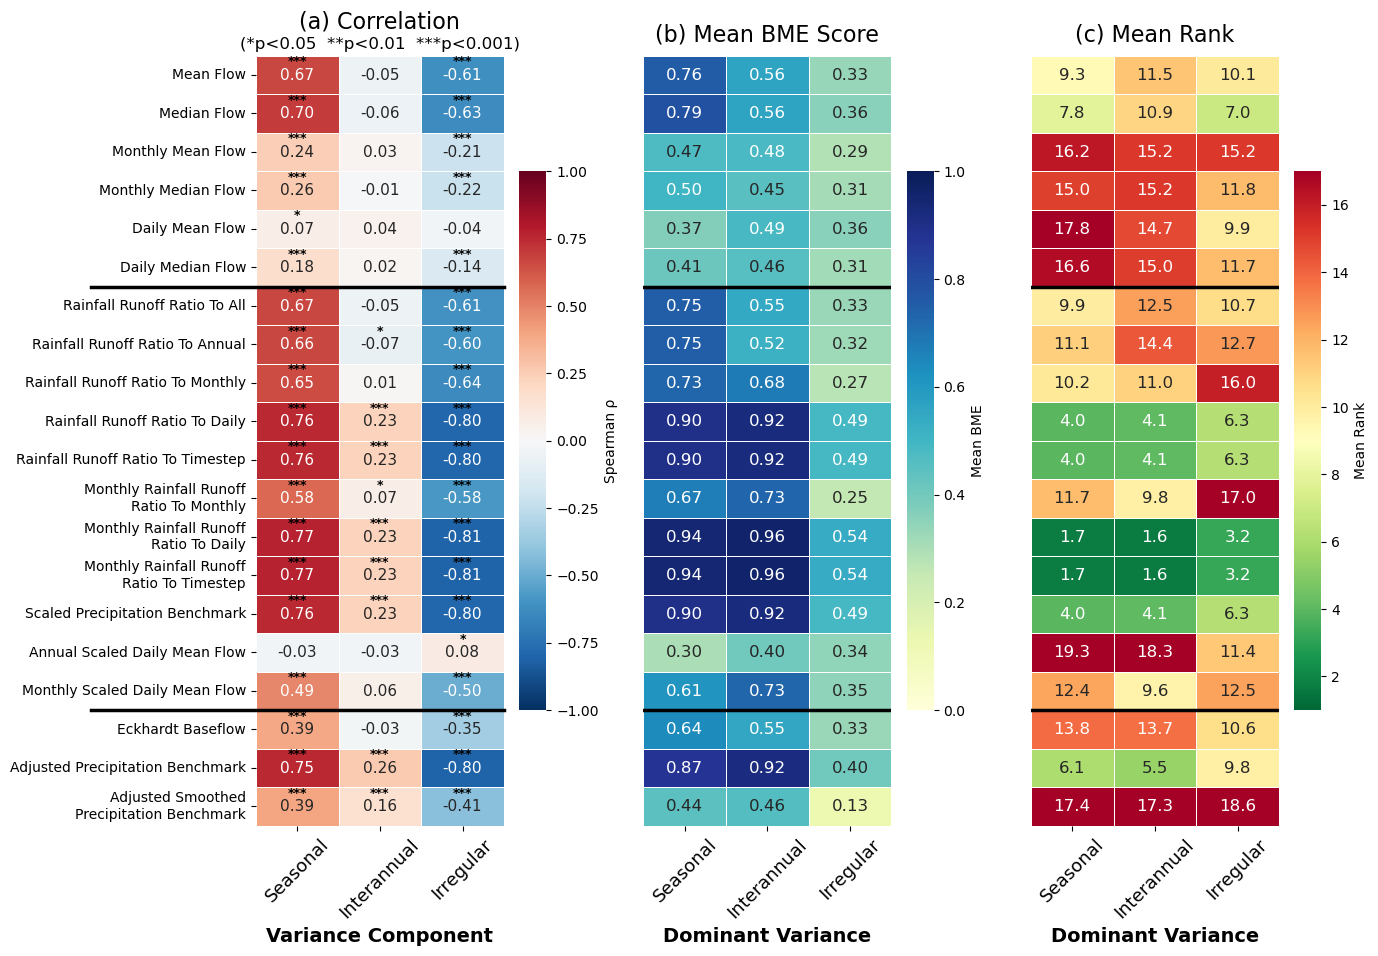

In [11]:
# 3. Create combined heatmap
fig = plot_combined_heatmap_analysis(results, rank_summary)
plt.savefig(f'{output_dir}/combined_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/combined_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Variance Type Boxplots


Catchment counts by dominant variance:
dominant_variance
interannual     27
irregular      675
seasonal       258
Name: catchment, dtype: int64

Fixed benchmark order (based on seasonal median, descending):
   1. Monthly Rainfall Runoff Ratio To Daily             (median=0.968)
   2. Monthly Rainfall Runoff Ratio To Timestep          (median=0.968)
   3. Rainfall Runoff Ratio To Timestep                  (median=0.941)
   4. Rainfall Runoff Ratio To Daily                     (median=0.941)
   5. Scaled Precipitation Benchmark                     (median=0.941)
   6. Adjusted Precipitation Benchmark                   (median=0.927)
   7. Median Flow                                        (median=0.847)
   8. Rainfall Runoff Ratio To Monthly                   (median=0.823)
   9. Mean Flow                                          (median=0.822)
  10. Rainfall Runoff Ratio To All                       (median=0.821)
  11. Rainfall Runoff Ratio To Annual                    (median=0.818)


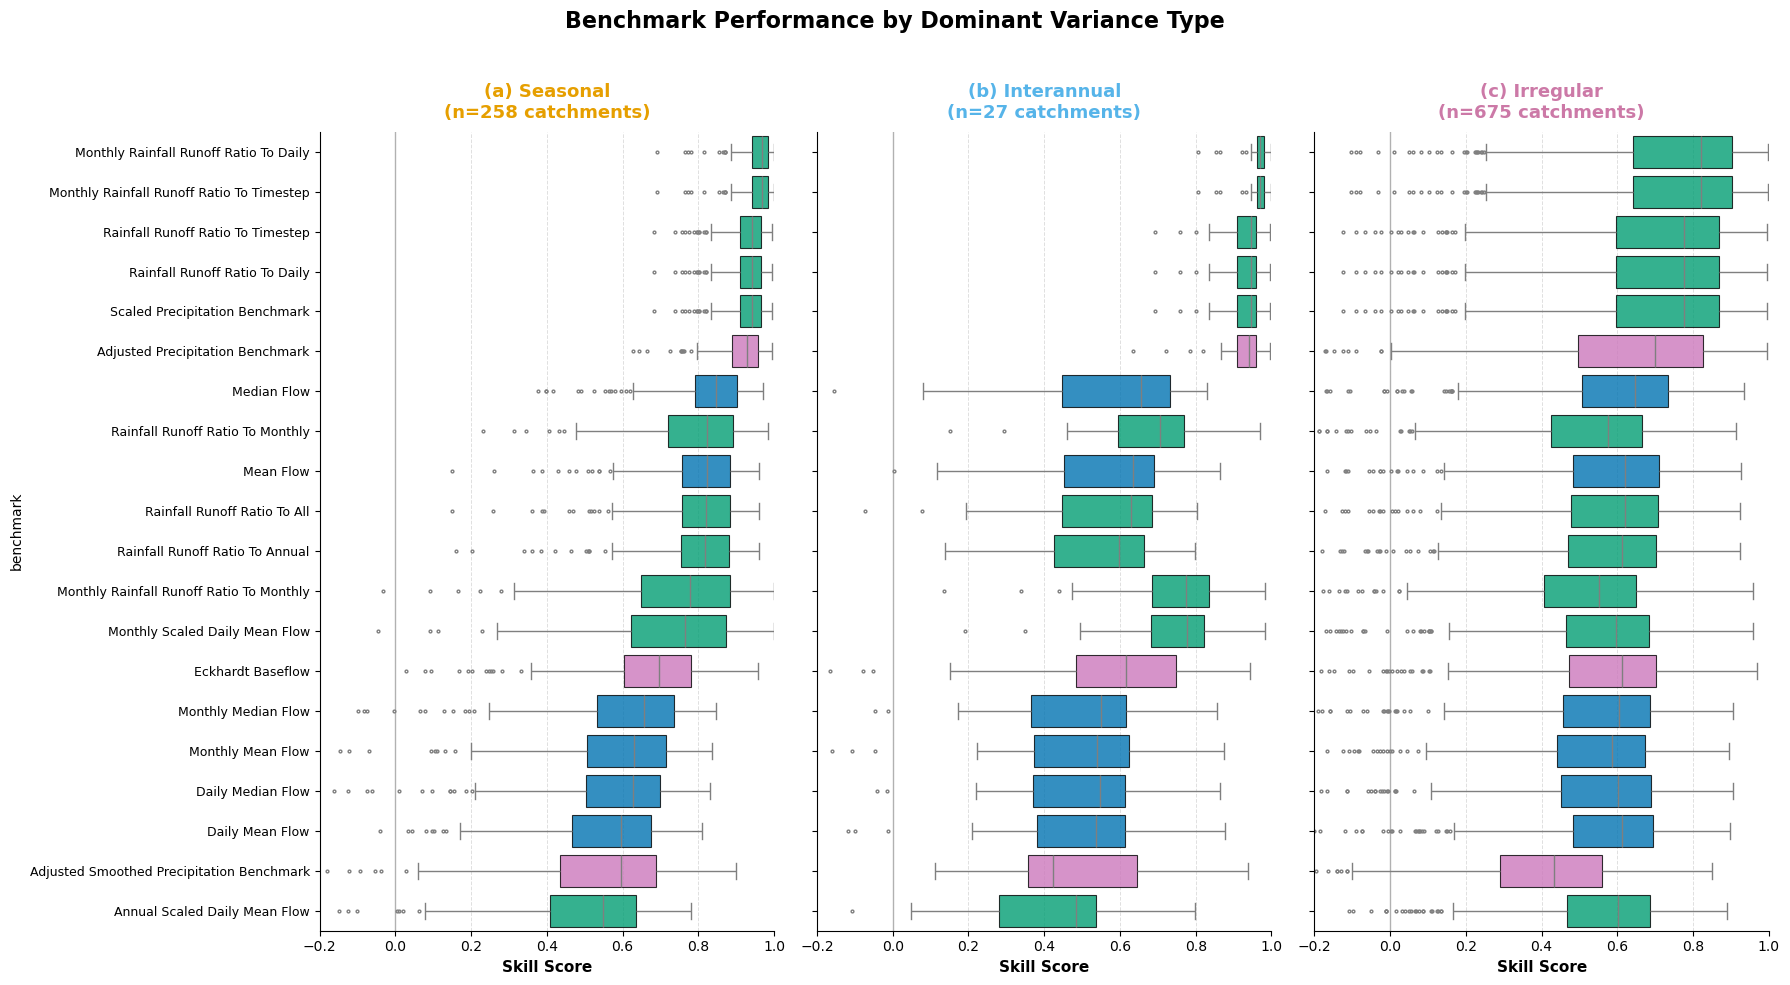

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define categories
categories = {
    'Streamflow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow"
    ],
    'P&S': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
        "bm_annual_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
    ],
    'Models': [
        "bm_eckhardt_baseflow",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
    ],
    'Ensemble': ['highest', 'lowest']
}

# Define color palette
palette = {
    'Streamflow': '#0173B2',              # Deep blue
    'P&S': '#029E73',   # Teal/green
    'Models': '#CC78BC',            # Purple/magenta
    'Ensemble': '#CA3542'           # Red
}

# Clean labels function
def clean_label(name):
    name = name.replace("bm_", "")
    name = name.replace("_", " ")
    return name.title()


# ============================================================================
# Identify dominant variance for each catchment
# ============================================================================
def categorize_catchments_by_variance(df):
    """Categorize catchments by dominant variance component"""
    df_cat = df.copy()
    
    # Get dominant variance for each catchment
    catchment_variance = df_cat.groupby('catchment')[
        ['obs_seasonal_var', 'obs_interannual_var', 'obs_irregular_var']
    ].first()
    
    catchment_variance['dominant_variance'] = catchment_variance.idxmax(axis=1)
    catchment_variance['dominant_variance'] = (
        catchment_variance['dominant_variance']
        .str.replace('obs_', '')
        .str.replace('_var', '')
    )
    
    # Merge back to main dataframe
    df_cat = df_cat.merge(
        catchment_variance[['dominant_variance']], 
        left_on='catchment', 
        right_index=True
    )
    
    return df_cat


# Filter for desired period
df_period = df[df['period'] == period].copy()

# Categorize catchments by dominant variance
df_period = categorize_catchments_by_variance(df_period)

# Get counts for each variance type
variance_counts = df_period.groupby('dominant_variance')['catchment'].nunique()
print("\nCatchment counts by dominant variance:")
print(variance_counts)


# ============================================================================
# Determine FIXED benchmark order based on SEASONAL median (ascending)
# ============================================================================
df_seasonal = df_period[df_period['dominant_variance'] == 'seasonal'].copy()

# Compute median for seasonal catchments and sort (descending for best at bottom)
seasonal_median_order = (
    df_seasonal.groupby('benchmark', observed=False)['skill_score']
    .median()
    .sort_values(ascending=False)  # Descending = best at bottom, worst at top
)

# Create FIXED benchmark order and corresponding colors
benchmark_order = []
benchmark_colors = []
for b in seasonal_median_order.index:
    for cat, benchmarks in categories.items():
        if b in benchmarks and b in df_period['benchmark'].unique():
            benchmark_order.append(b)
            benchmark_colors.append(palette[cat])
            break

# Clean labels (will be used for all plots)
cleaned_labels = [clean_label(b) for b in benchmark_order]

print(f"\nFixed benchmark order (based on seasonal median, descending):")
for i, (b, label) in enumerate(zip(benchmark_order, cleaned_labels), 1):
    median_val = seasonal_median_order[b]
    print(f"  {i:2d}. {label:50s} (median={median_val:.3f})")


# ============================================================================
# Create 3-panel figure
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

variance_types = ['seasonal', 'interannual', 'irregular']
variance_labels = {
    'seasonal': 'Seasonal',
    'interannual': 'Interannual', 
    'irregular': 'Irregular'
}
variance_colors = {
    'seasonal': '#E69F00',      # Orange
    'interannual': '#56B4E9',   # Light blue
    'irregular': '#CC79A7'      # Pink/purple
}

# For each variance type, create a subplot
for idx, var_type in enumerate(variance_types):
    ax = axes[idx]
    
    # Filter data for this variance type
    df_var = df_period[df_period['dominant_variance'] == var_type].copy()
    
    if len(df_var) == 0:
        ax.text(0.5, 0.5, f'No data\nfor {variance_labels[var_type]}', 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f'({chr(97+idx)}) {variance_labels[var_type]}\n(n=0)', 
                     fontsize=13, weight='bold', pad=10)
        continue
    
    # Use the FIXED benchmark order (don't recalculate per variance type)
    # Ensure categorical order
    df_var['benchmark'] = pd.Categorical(
        df_var['benchmark'],
        categories=benchmark_order,
        ordered=True
    )
    
    # Plot boxplot
    sns.boxplot(
        data=df_var,
        y='benchmark',
        x='skill_score',
        fliersize=2,
        linewidth=1.0,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes manually
    for patch, color in zip(ax.patches, benchmark_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.8)
        patch.set_linewidth(0.8)
    
    # Format y-axis labels (only for leftmost plot)
    if idx == 0:
        ax.set_yticks(range(len(benchmark_order)))
        ax.set_yticklabels(cleaned_labels, fontsize=9)
    else:
        ax.set_ylabel('')
    
    # Format x-axis
    ax.set_xlabel('Skill Score', fontsize=11, weight='bold')
    ax.set_xlim(-0.2, 1)
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='x', labelsize=10)
    
    # Add title with count
    n_catchments = df_var['catchment'].nunique()
    ax.set_title(
        f'({chr(97+idx)}) {variance_labels[var_type]}\n(n={n_catchments} catchments)', 
        fontsize=13, weight='bold', pad=10,
        color=variance_colors[var_type]
    )
    
    # Add grid and styling
    ax.grid(axis='x', linestyle='--', alpha=0.4, linewidth=0.7)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=1.0, alpha=0.6, zorder=0)
    sns.despine(ax=ax, top=True, right=True)

# Overall title
fig.suptitle(
    'Benchmark Performance by Dominant Variance Type', 
    fontsize=16, weight='bold', y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Save figure
# plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_by_variance.png', 
#             dpi=300, bbox_inches='tight')
# plt.savefig(f'{output_dir}/{plot_prefix}_{period}_boxplot_by_variance.pdf', 
#             dpi=300, bbox_inches='tight')
plt.show()




### Catchment Attributes


CREATING COMBINED FIGURE: ALL DATA + VARIANCE + RUNOFF RATIO STRATIFICATION


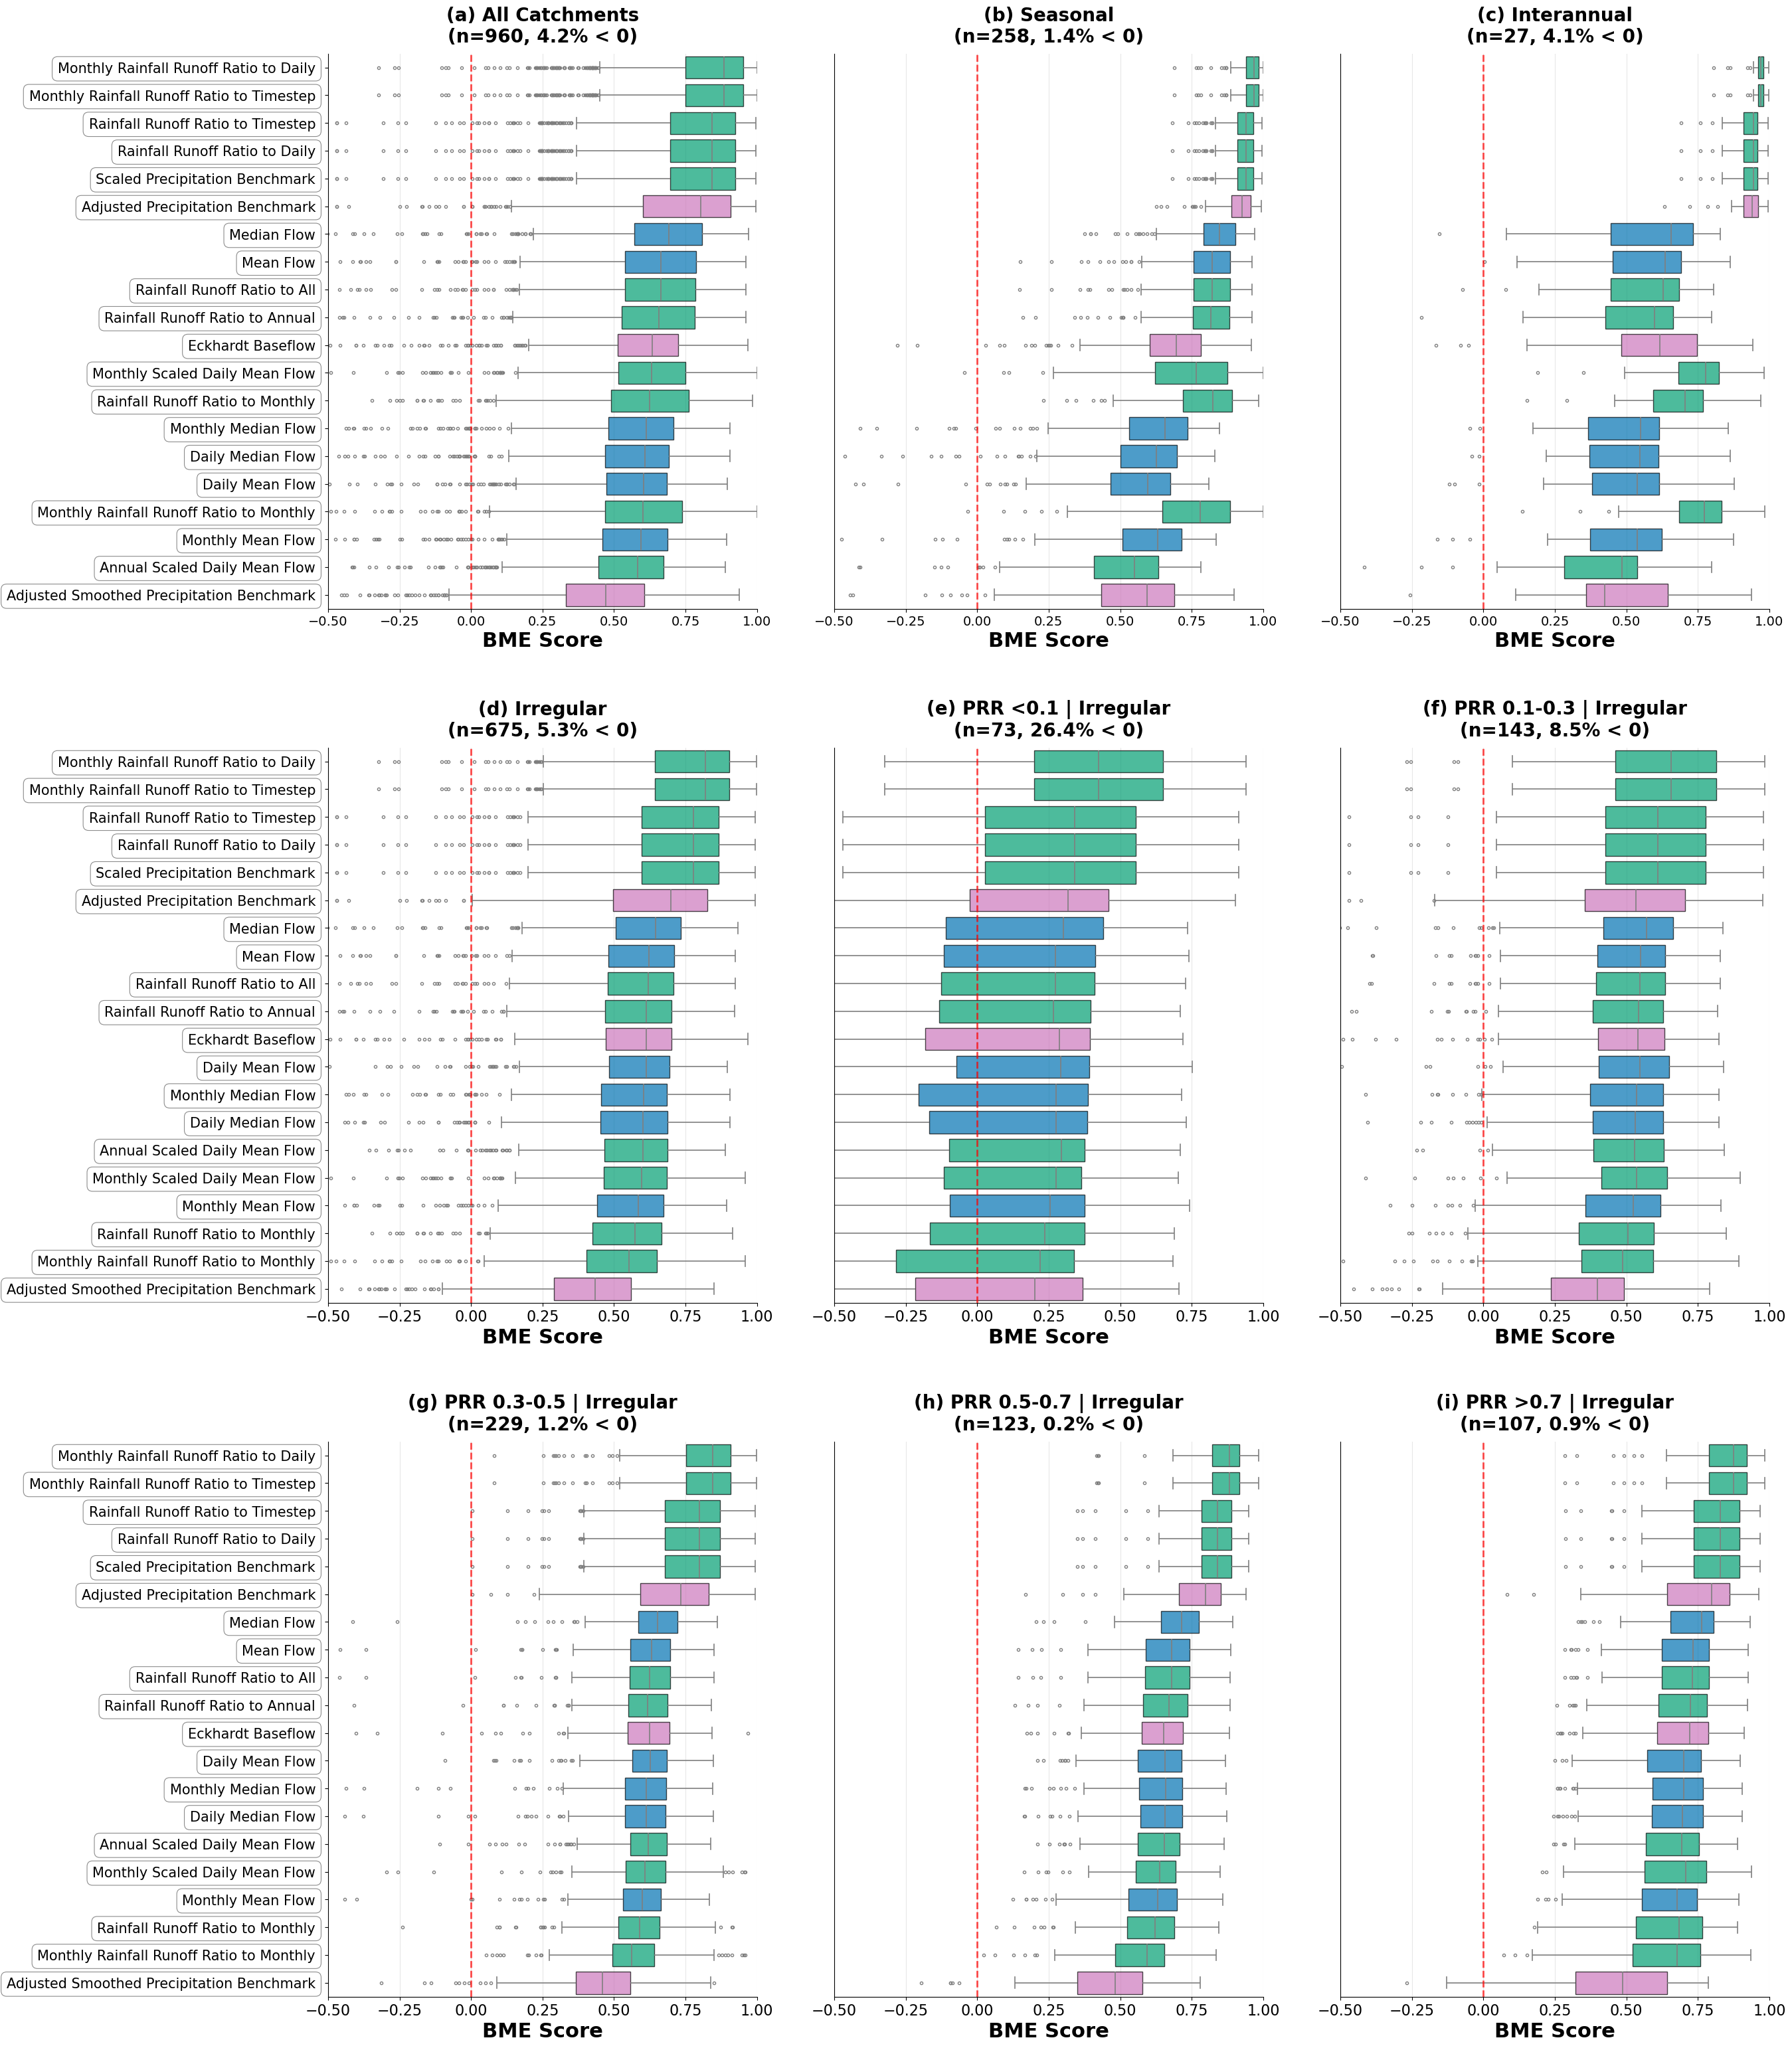


COMBINED STATISTICS SUMMARY

ROW 1 - ALL DATA & VARIANCE TYPES:
--------------------------------------------------------------------------------

All Catchments:
  Catchments: 960
  Median skill: 0.666
  % negative: 4.2%

Seasonal:
  Catchments: 258
  Median skill: 0.805
  % negative: 1.4%

Interannual:
  Catchments: 27
  Median skill: 0.704
  % negative: 4.1%

Irregular:
  Catchments: 675
  Median skill: 0.627
  % negative: 5.3%

ROWS 2-3 - IRREGULAR & RUNOFF RATIO CLASSES:
--------------------------------------------------------------------------------

Irregular (all):
  Catchments: 675
  Median skill: 0.627
  % negative: 5.3%

PRR <0.1:
  Catchments: 73
  Mean runoff ratio: 0.052
  Median skill: 0.284
  % negative: 26.4%
  Best benchmark: Monthly Rainfall Runoff Ratio to Daily (median=0.424)

PRR 0.1-0.3:
  Catchments: 143
  Mean runoff ratio: 0.222
  Median skill: 0.546
  % negative: 8.5%
  Best benchmark: Monthly Rainfall Runoff Ratio to Daily (median=0.657)

PRR 0.3-0.5:
  Catc

In [18]:
# ============================================================================
# Update format function - no prefixes, no wrapping
# ============================================================================

def format_benchmark_name(benchmark_name):
    """Format benchmark names for display without category prefixes"""
    
    # Clean name and handle capitalization
    clean_name = benchmark_name.replace('bm_', '').replace('_', ' ')
    
    # Capitalize properly (not words like 'to', 'and', 'with', etc.)
    words = clean_name.split()
    capitalized_words = []
    for i, word in enumerate(words):
        if i == 0 or word.lower() not in ['to', 'and', 'with', 'or', 'of', 'the', 'a', 'an']:
            capitalized_words.append(word.capitalize())
        else:
            capitalized_words.append(word.lower())
    clean_name = ' '.join(capitalized_words)
    
    return clean_name

# ============================================================================
# Combined Figure: All Data + Variance Types (Row 1) + Runoff Ratio Classes (Rows 2-3)
# ============================================================================

print("\n" + "="*80)
print("CREATING COMBINED FIGURE: ALL DATA + VARIANCE + RUNOFF RATIO STRATIFICATION")
print("="*80)

# Filter for irregular variance catchments only for runoff analysis
df_irregular = df_merged[df_merged['dominant_variance'] == 'irregular'].copy()

# Create 5 runoff ratio bins for irregular catchments (combining 0.1-0.2 and 0.2-0.3)
df_irregular['runoff_class_5bin'] = pd.cut(
    df_irregular['runoff_ratio_mean'],
    bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
    labels=['PRR <0.1', 'PRR 0.1-0.3', 'PRR 0.3-0.5', 
            'PRR 0.5-0.7', 'PRR >0.7']
)

# ============================================================================
# Create 3-row × 3-column figure
# ============================================================================

fig = plt.figure(figsize=(28, 38))  # Reduced height
gs = fig.add_gridspec(3, 3, hspace=0.25, wspace=0.18)  # Much less vertical space

# ============================================================================
# ROW 1: All Data + Variance Types (Seasonal, Interannual, Irregular)
# ============================================================================

variance_types = ['all', 'seasonal', 'interannual', 'irregular']
variance_labels = {
    'all': 'All Catchments',
    'seasonal': 'Seasonal',
    'interannual': 'Interannual', 
    'irregular': 'Irregular'
}
variance_colors = {
    'all': '#000000',           # Black
    'seasonal': '#E69F00',      # Orange
    'interannual': '#56B4E9',   # Light blue
    'irregular': '#CC79A7'      # Pink/purple
}

# Calculate benchmark order for ROW 1 based on "All Catchments"
df_all = df_period.copy()
row1_benchmark_order = (
    df_all.groupby('benchmark', observed=True)['skill_score']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

for col, var_type in enumerate(variance_types[:3]):  # Only first 3 for row 1
    ax = fig.add_subplot(gs[0, col])
    
    # Filter data for this variance type
    if var_type == 'all':
        df_var = df_period.copy()
    else:
        df_var = df_period[df_period['dominant_variance'] == var_type].copy()
    
    if len(df_var) == 0:
        ax.text(0.5, 0.5, f'No data\nfor {variance_labels[var_type]}', 
                ha='center', va='center', fontsize=18, transform=ax.transAxes)
        ax.set_title(f'({chr(97+col)}) {variance_labels[var_type]}\n(n=0)', 
                     fontsize=22, weight='bold', color='black')
        continue
    
    # Use the FIXED benchmark order from "All Catchments"
    df_var['benchmark'] = pd.Categorical(
        df_var['benchmark'],
        categories=row1_benchmark_order,
        ordered=True
    )
    
    # Plot
    sns.boxplot(
        data=df_var,
        y='benchmark',
        x='skill_score',
        fliersize=3,
        linewidth=1.2,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes
    box_colors = []
    for benchmark in row1_benchmark_order:
        for cat, benchmarks in categories.items():
            if benchmark in benchmarks:
                box_colors.append(palette[cat])
                break
    
    for patch, color in zip(ax.patches, box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.7)
        patch.set_linewidth(1.0)
    
    # Format y-axis (only leftmost)
    if col == 0:
        formatted_labels = [format_benchmark_name(b) for b in row1_benchmark_order]
        ax.set_yticks(range(len(row1_benchmark_order)))
        ax.set_yticklabels(formatted_labels, fontsize=15)
        ax.set_ylabel('')
        
        # Add borders to y-tick labels
        for tick in ax.get_yticklabels():
            tick.set_bbox(dict(boxstyle='round,pad=0.4', 
                              facecolor='white', 
                              edgecolor='gray', 
                              linewidth=0.8,
                              alpha=0.9))
    else:
        ax.set_yticks([])
        ax.set_ylabel('')
    
    ax.set_xlabel('BME Score', fontsize=22, weight='bold')  # Changed from 16 to 22
    ax.set_xlim(-0.5, 1.0)
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', pad=10)
    ax.grid(axis='x', alpha=0.3, linewidth=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Title with statistics
    n_catchments = df_var['catchment'].nunique()
    pct_negative = (df_var['skill_score'] < 0).sum() / len(df_var) * 100
    
    ax.set_title(
        f'({chr(97+col)}) {variance_labels[var_type]}\n'
        f'(n={n_catchments}, {pct_negative:.1f}% < 0)', 
        fontsize=20, weight='bold',
        color='black',
        pad=12
    )
    
    sns.despine(ax=ax, top=True, right=True)

# ============================================================================
# ROWS 2-3: Runoff Ratio Classes (Irregular Catchments Only)
# ============================================================================

# Calculate benchmark order for ROWS 2-3 based on "Irregular" (first panel in row 2)
row23_benchmark_order = (
    df_irregular.groupby('benchmark', observed=True)['skill_score']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

runoff_classes = ['PRR <0.1', 'PRR 0.1-0.3', 'PRR 0.3-0.5', 
                  'PRR 0.5-0.7', 'PRR >0.7']

# We have 5 bins + 1 irregular panel to fill 6 spots
for idx in range(6):
    if idx == 0:
        # First position in row 2: show full irregular (no runoff filtering)
        row = 1
        col = 0
        ax = fig.add_subplot(gs[row, col])
        
        df_bin = df_irregular.copy()
        panel_label = 'Irregular'
        
    else:
        # Remaining 5 positions: runoff ratio bins
        row = 1 + ((idx) // 3)
        col = (idx) % 3
        ax = fig.add_subplot(gs[row, col])
        
        runoff_class = runoff_classes[idx - 1]
        df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class].copy()
        panel_label = f'{runoff_class} | Irregular'
    
    if len(df_bin) == 0:
        ax.text(0.5, 0.5, 'No data', 
               ha='center', va='center', fontsize=18, transform=ax.transAxes)
        ax.set_title(f'({chr(97+3+idx)}) {panel_label}\n(n=0)', 
                     fontsize=20, weight='bold', color='black')
        continue
    
    # Use the FIXED benchmark order from "Irregular" panel
    df_bin['benchmark'] = pd.Categorical(
        df_bin['benchmark'],
        categories=row23_benchmark_order,
        ordered=True
    )
    
    # Plot
    sns.boxplot(
        data=df_bin,
        y='benchmark',
        x='skill_score',
        fliersize=3,
        linewidth=1.2,
        color='lightgrey',
        ax=ax
    )
    
    # Color boxes
    box_colors = []
    for benchmark in row23_benchmark_order:
        for cat, benchmarks in categories.items():
            if benchmark in benchmarks:
                box_colors.append(palette[cat])
                break
    
    for patch, color in zip(ax.patches, box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('k')
        patch.set_alpha(0.7)
        patch.set_linewidth(1.0)
    
    # Format y-axis (only leftmost column)
    if col == 0:
        formatted_labels = [format_benchmark_name(b) for b in row23_benchmark_order]
        ax.set_yticks(range(len(row23_benchmark_order)))
        ax.set_yticklabels(formatted_labels, fontsize=15)
        ax.set_ylabel('')
        
        # Add borders to y-tick labels
        for tick in ax.get_yticklabels():
            tick.set_bbox(dict(boxstyle='round,pad=0.4', 
                              facecolor='white', 
                              edgecolor='gray', 
                              linewidth=0.8,
                              alpha=0.9))
    else:
        ax.set_yticks([])
        ax.set_ylabel('')
    
    ax.set_xlabel('BME Score', fontsize=22, weight='bold')  # Changed from 28 to 22
    ax.set_xlim(-0.5, 1.0)
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', pad=10)
    ax.grid(axis='x', alpha=0.3, linewidth=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Title with statistics
    n_catchments = df_bin['catchment'].nunique()
    median_skill = df_bin['skill_score'].median()
    pct_negative = (df_bin['skill_score'] < 0).sum() / len(df_bin) * 100
    
    ax.set_title(
        f'({chr(97+3+idx)}) {panel_label}\n'
        f'(n={n_catchments}, {pct_negative:.1f}% < 0)',
        fontsize=20, weight='bold',
        color='black',
        pad=12
    )
    
    sns.despine(ax=ax, top=True, right=True)

# # Overall title
# fig.suptitle(
#     'Benchmark Performance: Complete Dataset, Variance Types, and Runoff Ratio Stratification\n'
#     '(Row 1: All data and variance types | Rows 2-3: Irregular catchments stratified by runoff ratio)',
#     fontsize=18, weight='bold', y=0.997)  # Adjusted

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.png', 
            dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Print combined statistics
# ============================================================================

print("\n" + "="*80)
print("COMBINED STATISTICS SUMMARY")
print("="*80)

print("\nROW 1 - ALL DATA & VARIANCE TYPES:")
print("-" * 80)

# All data
df_all = df_period
print(f"\nAll Catchments:")
print(f"  Catchments: {df_all['catchment'].nunique()}")
print(f"  Median skill: {df_all['skill_score'].median():.3f}")
print(f"  % negative: {(df_all['skill_score'] < 0).sum() / len(df_all) * 100:.1f}%")

for var_type in ['seasonal', 'interannual', 'irregular']:
    df_var = df_period[df_period['dominant_variance'] == var_type]
    if len(df_var) > 0:
        print(f"\n{variance_labels[var_type]}:")
        print(f"  Catchments: {df_var['catchment'].nunique()}")
        print(f"  Median skill: {df_var['skill_score'].median():.3f}")
        print(f"  % negative: {(df_var['skill_score'] < 0).sum() / len(df_var) * 100:.1f}%")

print("\n" + "="*80)
print("ROWS 2-3 - IRREGULAR & RUNOFF RATIO CLASSES:")
print("-" * 80)

# Full irregular
print(f"\nIrregular (all):")
print(f"  Catchments: {df_irregular['catchment'].nunique()}")
print(f"  Median skill: {df_irregular['skill_score'].median():.3f}")
print(f"  % negative: {(df_irregular['skill_score'] < 0).sum() / len(df_irregular) * 100:.1f}%")

for runoff_class in runoff_classes:
    df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class]
    
    if len(df_bin) == 0:
        print(f"\n{runoff_class}: No data")
        continue
    
    print(f"\n{runoff_class}:")
    print(f"  Catchments: {df_bin['catchment'].nunique()}")
    print(f"  Mean runoff ratio: {df_bin['runoff_ratio_mean'].mean():.3f}")
    print(f"  Median skill: {df_bin['skill_score'].median():.3f}")
    print(f"  % negative: {(df_bin['skill_score'] < 0).sum() / len(df_bin) * 100:.1f}%")
    
    best_bm = df_bin.groupby('benchmark', observed=True)['skill_score'].median().idxmax()
    best_score = df_bin.groupby('benchmark', observed=True)['skill_score'].median().max()
    print(f"  Best benchmark: {format_benchmark_name(best_bm)} (median={best_score:.3f})")

In [14]:
# # ============================================================================
# # Update format function - no prefixes, no wrapping
# # ============================================================================

# def format_benchmark_name(benchmark_name):
#     """Format benchmark names for display without category prefixes"""
    
#     # Clean name and handle capitalization
#     clean_name = benchmark_name.replace('bm_', '').replace('_', ' ')
    
#     # Capitalize properly (not words like 'to', 'and', 'with', etc.)
#     words = clean_name.split()
#     capitalized_words = []
#     for i, word in enumerate(words):
#         if i == 0 or word.lower() not in ['to', 'and', 'with', 'or', 'of', 'the', 'a', 'an']:
#             capitalized_words.append(word.capitalize())
#         else:
#             capitalized_words.append(word.lower())
#     clean_name = ' '.join(capitalized_words)
    
#     return clean_name

# # ============================================================================
# # Combined Figure: All Data + Variance Types (Row 1) + Runoff Ratio Classes (Rows 2-3)
# # ============================================================================

# print("\n" + "="*80)
# print("CREATING COMBINED FIGURE: ALL DATA + VARIANCE + RUNOFF RATIO STRATIFICATION")
# print("="*80)

# # Filter for irregular variance catchments only for runoff analysis
# df_irregular = df_merged[df_merged['dominant_variance'] == 'irregular'].copy()

# # Create 5 runoff ratio bins for irregular catchments (combining 0.1-0.2 and 0.2-0.3)
# df_irregular['runoff_class_5bin'] = pd.cut(
#     df_irregular['runoff_ratio_mean'],
#     bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
#     labels=['RRR <0.1', 'RRR 0.1-0.3', 'RRR 0.3-0.5', 
#             'RRR 0.5-0.7', 'RRR >0.7']
# )

# # ============================================================================
# # Create 3-row × 3-column figure
# # ============================================================================

# fig = plt.figure(figsize=(28, 38))  # Reduced height
# gs = fig.add_gridspec(3, 3, hspace=0.25, wspace=0.18)  # Much less vertical space

# # ============================================================================
# # ROW 1: All Data + Variance Types (Seasonal, Interannual, Irregular)
# # ============================================================================

# variance_types = ['all', 'seasonal', 'interannual', 'irregular']
# variance_labels = {
#     'all': 'All Catchments',
#     'seasonal': 'Seasonal',
#     'interannual': 'Interannual', 
#     'irregular': 'Irregular'
# }
# variance_colors = {
#     'all': '#000000',           # Black
#     'seasonal': '#E69F00',      # Orange
#     'interannual': '#56B4E9',   # Light blue
#     'irregular': '#CC79A7'      # Pink/purple
# }

# # Calculate benchmark order for ROW 1 based on "All Catchments"
# df_all = df_period.copy()
# row1_benchmark_order = (
#     df_all.groupby('benchmark', observed=True)['skill_score']
#     .median()
#     .sort_values(ascending=False)
#     .index.tolist()
# )

# for col, var_type in enumerate(variance_types[:3]):  # Only first 3 for row 1
#     ax = fig.add_subplot(gs[0, col])
    
#     # Filter data for this variance type
#     if var_type == 'all':
#         df_var = df_period.copy()
#     else:
#         df_var = df_period[df_period['dominant_variance'] == var_type].copy()
    
#     if len(df_var) == 0:
#         ax.text(0.5, 0.5, f'No data\nfor {variance_labels[var_type]}', 
#                 ha='center', va='center', fontsize=16, transform=ax.transAxes)
#         ax.set_title(f'({chr(97+col)}) {variance_labels[var_type]}\n(n=0)', 
#                      fontsize=16, weight='bold', color='black')
#         continue
    
#     # Use the FIXED benchmark order from "All Catchments"
#     df_var['benchmark'] = pd.Categorical(
#         df_var['benchmark'],
#         categories=row1_benchmark_order,
#         ordered=True
#     )
    
#     # Plot
#     sns.boxplot(
#         data=df_var,
#         y='benchmark',
#         x='skill_score',
#         fliersize=3,
#         linewidth=1.2,
#         color='lightgrey',
#         ax=ax
#     )
    
#     # Color boxes
#     box_colors = []
#     for benchmark in row1_benchmark_order:
#         for cat, benchmarks in categories.items():
#             if benchmark in benchmarks:
#                 box_colors.append(palette[cat])
#                 break
    
#     for patch, color in zip(ax.patches, box_colors):
#         patch.set_facecolor(color)
#         patch.set_edgecolor('k')
#         patch.set_alpha(0.7)
#         patch.set_linewidth(1.0)
    
#     # Format y-axis (only leftmost)
#     if col == 0:
#         formatted_labels = [format_benchmark_name(b) for b in row1_benchmark_order]
#         ax.set_yticks(range(len(row1_benchmark_order)))
#         ax.set_yticklabels(formatted_labels, fontsize=11)
#         ax.set_ylabel('')
        
#         # Add borders to y-tick labels
#         for tick in ax.get_yticklabels():
#             tick.set_bbox(dict(boxstyle='round,pad=0.4', 
#                               facecolor='white', 
#                               edgecolor='gray', 
#                               linewidth=0.8,
#                               alpha=0.9))
#     else:
#         ax.set_yticks([])
#         ax.set_ylabel('')
    
#     ax.set_xlabel('BME Score', fontsize=14, weight='bold')
#     ax.set_xlim(-0.5, 1.0)
#     ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', pad=10)
#     ax.grid(axis='x', alpha=0.3, linewidth=0.8)
#     ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
#     # Title with statistics
#     n_catchments = df_var['catchment'].nunique()
#     pct_negative = (df_var['skill_score'] < 0).sum() / len(df_var) * 100
    
#     ax.set_title(
#         f'({chr(97+col)}) {variance_labels[var_type]}\n'
#         f'(n={n_catchments}, {pct_negative:.1f}% < 0)', 
#         fontsize=15, weight='bold',
#         color='black',
#         pad=12  # Reduced padding
#     )
    
#     sns.despine(ax=ax, top=True, right=True)

# # ============================================================================
# # ROWS 2-3: Runoff Ratio Classes (Irregular Catchments Only)
# # ============================================================================

# # Calculate benchmark order for ROWS 2-3 based on "Irregular" (first panel in row 2)
# row23_benchmark_order = (
#     df_irregular.groupby('benchmark', observed=True)['skill_score']
#     .median()
#     .sort_values(ascending=False)
#     .index.tolist()
# )

# runoff_classes = ['RRR <0.1', 'RRR 0.1-0.3', 'RRR 0.3-0.5', 
#                   'RRR 0.5-0.7', 'RRR >0.7']

# # We have 5 bins + 1 irregular panel to fill 6 spots
# for idx in range(6):
#     if idx == 0:
#         # First position in row 2: show full irregular (no runoff filtering)
#         row = 1
#         col = 0
#         ax = fig.add_subplot(gs[row, col])
        
#         df_bin = df_irregular.copy()
#         panel_label = 'Irregular'
        
#     else:
#         # Remaining 5 positions: runoff ratio bins
#         row = 1 + ((idx) // 3)
#         col = (idx) % 3
#         ax = fig.add_subplot(gs[row, col])
        
#         runoff_class = runoff_classes[idx - 1]
#         df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class].copy()
#         panel_label = f'{runoff_class} | Irregular'
    
#     if len(df_bin) == 0:
#         ax.text(0.5, 0.5, 'No data', 
#                ha='center', va='center', fontsize=16, transform=ax.transAxes)
#         ax.set_title(f'({chr(97+3+idx)}) {panel_label}\n(n=0)', 
#                      fontsize=15, weight='bold', color='black')
#         continue
    
#     # Use the FIXED benchmark order from "Irregular" panel
#     df_bin['benchmark'] = pd.Categorical(
#         df_bin['benchmark'],
#         categories=row23_benchmark_order,
#         ordered=True
#     )
    
#     # Plot
#     sns.boxplot(
#         data=df_bin,
#         y='benchmark',
#         x='skill_score',
#         fliersize=3,
#         linewidth=1.2,
#         color='lightgrey',
#         ax=ax
#     )
    
#     # Color boxes
#     box_colors = []
#     for benchmark in row23_benchmark_order:
#         for cat, benchmarks in categories.items():
#             if benchmark in benchmarks:
#                 box_colors.append(palette[cat])
#                 break
    
#     for patch, color in zip(ax.patches, box_colors):
#         patch.set_facecolor(color)
#         patch.set_edgecolor('k')
#         patch.set_alpha(0.7)
#         patch.set_linewidth(1.0)
    
#     # Format y-axis (only leftmost column)
#     if col == 0:
#         formatted_labels = [format_benchmark_name(b) for b in row23_benchmark_order]
#         ax.set_yticks(range(len(row23_benchmark_order)))
#         ax.set_yticklabels(formatted_labels, fontsize=11)
#         ax.set_ylabel('')
        
#         # Add borders to y-tick labels
#         for tick in ax.get_yticklabels():
#             tick.set_bbox(dict(boxstyle='round,pad=0.4', 
#                               facecolor='white', 
#                               edgecolor='gray', 
#                               linewidth=0.8,
#                               alpha=0.9))
#     else:
#         ax.set_yticks([])
#         ax.set_ylabel('')
    
#     ax.set_xlabel('BME Score', fontsize=14, weight='bold')
#     ax.set_xlim(-0.5, 1.0)
#     ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', pad=10)
#     ax.grid(axis='x', alpha=0.3, linewidth=0.8)
#     ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
#     # Title with statistics
#     n_catchments = df_bin['catchment'].nunique()
#     median_skill = df_bin['skill_score'].median()
#     pct_negative = (df_bin['skill_score'] < 0).sum() / len(df_bin) * 100
    
#     ax.set_title(
#         f'({chr(97+3+idx)}) {panel_label}\n'
#         f'(n={n_catchments}, {pct_negative:.1f}% < 0)',
#         fontsize=14, weight='bold',
#         color='black',
#         pad=12  # Reduced padding
#     )
    
#     sns.despine(ax=ax, top=True, right=True)

# # # Overall title
# # fig.suptitle(
# #     'Benchmark Performance: Complete Dataset, Variance Types, and Runoff Ratio Stratification\n'
# #     '(Row 1: All data and variance types | Rows 2-3: Irregular catchments stratified by runoff ratio)',
# #     fontsize=18, weight='bold', y=0.997)  # Adjusted

# # Save figure
# plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.png', 
#             dpi=300, bbox_inches='tight')
# plt.savefig(f'{output_dir}/{plot_prefix}_{period}_combined_all_variance_runoff.pdf', 
#             dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================================================
# # Print combined statistics
# # ============================================================================

# print("\n" + "="*80)
# print("COMBINED STATISTICS SUMMARY")
# print("="*80)

# print("\nROW 1 - ALL DATA & VARIANCE TYPES:")
# print("-" * 80)

# # All data
# df_all = df_period
# print(f"\nAll Catchments:")
# print(f"  Catchments: {df_all['catchment'].nunique()}")
# print(f"  Median skill: {df_all['skill_score'].median():.3f}")
# print(f"  % negative: {(df_all['skill_score'] < 0).sum() / len(df_all) * 100:.1f}%")

# for var_type in ['seasonal', 'interannual', 'irregular']:
#     df_var = df_period[df_period['dominant_variance'] == var_type]
#     if len(df_var) > 0:
#         print(f"\n{variance_labels[var_type]}:")
#         print(f"  Catchments: {df_var['catchment'].nunique()}")
#         print(f"  Median skill: {df_var['skill_score'].median():.3f}")
#         print(f"  % negative: {(df_var['skill_score'] < 0).sum() / len(df_var) * 100:.1f}%")

# print("\n" + "="*80)
# print("ROWS 2-3 - IRREGULAR & RUNOFF RATIO CLASSES:")
# print("-" * 80)

# # Full irregular
# print(f"\nIrregular (all):")
# print(f"  Catchments: {df_irregular['catchment'].nunique()}")
# print(f"  Median skill: {df_irregular['skill_score'].median():.3f}")
# print(f"  % negative: {(df_irregular['skill_score'] < 0).sum() / len(df_irregular) * 100:.1f}%")

# for runoff_class in runoff_classes:
#     df_bin = df_irregular[df_irregular['runoff_class_5bin'] == runoff_class]
    
#     if len(df_bin) == 0:
#         print(f"\n{runoff_class}: No data")
#         continue
    
#     print(f"\n{runoff_class}:")
#     print(f"  Catchments: {df_bin['catchment'].nunique()}")
#     print(f"  Mean runoff ratio: {df_bin['runoff_ratio_mean'].mean():.3f}")
#     print(f"  Median skill: {df_bin['skill_score'].median():.3f}")
#     print(f"  % negative: {(df_bin['skill_score'] < 0).sum() / len(df_bin) * 100:.1f}%")
    
#     best_bm = df_bin.groupby('benchmark', observed=True)['skill_score'].median().idxmax()
#     best_score = df_bin.groupby('benchmark', observed=True)['skill_score'].median().max()
#     print(f"  Best benchmark: {format_benchmark_name(best_bm)} (median={best_score:.3f})")

In [15]:
# Add this before calling the plot function
print("\n" + "="*80)
print("DIAGNOSTIC: Checking data filtering")
print("="*80)

# Total catchments in original data
total_catchments = df_merged[df_merged['period'] == period]['catchment'].nunique()
print(f"\nTotal catchments in period '{period}': {total_catchments}")

# Check mean flow benchmark availability
has_mean_flow = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['benchmark'] == 'bm_mean_flow')
]['catchment'].nunique()
print(f"Catchments with bm_mean_flow: {has_mean_flow}")

# Check by dominant variance
for var_type in ['seasonal', 'interannual', 'irregular']:
    count = df_merged[
        (df_merged['period'] == period) & 
        (df_merged['dominant_variance'] == var_type)
    ]['catchment'].nunique()
    print(f"Catchments with {var_type} variance: {count}")

# Check for missing runoff ratio
has_runoff = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['runoff_ratio_mean'].notna())
]['catchment'].nunique()
print(f"Catchments with runoff_ratio_mean: {has_runoff}")

# Check seasonal + irregular only
seasonal_irregular = df_merged[
    (df_merged['period'] == period) & 
    (df_merged['dominant_variance'].isin(['seasonal', 'irregular']))
]['catchment'].nunique()
print(f"Catchments with seasonal or irregular variance: {seasonal_irregular}")


DIAGNOSTIC: Checking data filtering

Total catchments in period 'validation': 960
Catchments with bm_mean_flow: 960
Catchments with seasonal variance: 258
Catchments with interannual variance: 27
Catchments with irregular variance: 675
Catchments with runoff_ratio_mean: 960
Catchments with seasonal or irregular variance: 933


### NSE vs BME

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_nse_vs_bme_scatter(df, period='all', save_prefix='nse_vs_bme'):
    """
    Create a scatter plot comparing mean flow benchmark (NSE) vs lowest benchmark (BME)
    Color-coded by dominant variance type and runoff ratio classes
    
    Parameters:
    -----------
    df : DataFrame with benchmark scores (merged_df with dominant_variance column)
    period : str, which period to analyze ('calibration', 'validation', 'all')
    save_prefix : str, prefix for output files
    """
    
    # Filter for the specified period
    df_period = df[df['period'] == period].copy()
    
    # Reset index if catchment is in index
    if 'catchment' not in df_period.columns:
        df_period = df_period.reset_index()
    
    # Get mean flow benchmark scores (NSE)
    df_nse = df_period[df_period['benchmark'] == 'bm_mean_flow'][['catchment', 'skill_score', 'dominant_variance']].copy()
    df_nse.columns = ['catchment', 'NSE', 'dominant_variance']
    
    # For each catchment, find the MINIMUM (worst) benchmark score (BME)
    if 'lowest' in df_period['benchmark'].values:
        df_bme = df_period[df_period['benchmark'] == 'lowest'][['catchment', 'skill_score']].copy()
        df_bme.columns = ['catchment', 'BME']
    else:
        # Find the worst (lowest/minimum) benchmark score for each catchment
        df_bme = df_period.groupby('catchment')['skill_score'].min().reset_index()
        df_bme.columns = ['catchment', 'BME']
    
    # Get runoff ratio for each catchment (from any row since it's catchment-specific)
    df_runoff = df_period.groupby('catchment')['runoff_ratio_mean'].first().reset_index()
    
    # Merge NSE, BME, and runoff ratio
    df_comparison = df_nse.merge(df_bme, on='catchment', how='inner')
    df_comparison = df_comparison.merge(df_runoff, on='catchment', how='inner')
    
    # Remove any NaN values
    df_comparison = df_comparison.dropna()
    
    # Filter for only seasonal and irregular variance
    df_comparison = df_comparison[df_comparison['dominant_variance'].isin(['seasonal', 'irregular'])].copy()
    
    # Create runoff ratio bins for irregular catchments
    df_comparison['runoff_class'] = 'N/A'
    irregular_mask = df_comparison['dominant_variance'] == 'irregular'
    df_comparison.loc[irregular_mask, 'runoff_class'] = pd.cut(
        df_comparison.loc[irregular_mask, 'runoff_ratio_mean'],
        bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
        labels=['PRR <0.1', 'PRR 0.1-0.3', 'PRR 0.3-0.5', 
                'PRR 0.5-0.7', 'PRR >0.7']  # Changed from RRR to PRR
    )
    
    # Create combined category for coloring
    df_comparison['category'] = df_comparison['dominant_variance']
    df_comparison.loc[irregular_mask, 'category'] = (
        'Irregular: ' + df_comparison.loc[irregular_mask, 'runoff_class'].astype(str)
    )
    
    # Capitalize seasonal
    df_comparison['category'] = df_comparison['category'].replace('seasonal', 'Seasonal')
    
    print(f"\n{'='*80}")
    print(f"NSE vs BME Comparison - {period.upper()} Period")
    print(f"{'='*80}")
    print(f"Number of catchments: {len(df_comparison)}")
    print(f"\nNSE (Mean Flow Benchmark) Statistics:")
    print(f"  Mean:   {df_comparison['NSE'].mean():.3f}")
    print(f"  Median: {df_comparison['NSE'].median():.3f}")
    print(f"  Min:    {df_comparison['NSE'].min():.3f}")
    print(f"  Max:    {df_comparison['NSE'].max():.3f}")
    
    print(f"\nBME (Worst Benchmark - Minimum Score) Statistics:")
    print(f"  Mean:   {df_comparison['BME'].mean():.3f}")
    print(f"  Median: {df_comparison['BME'].median():.3f}")
    print(f"  Min:    {df_comparison['BME'].min():.3f}")
    print(f"  Max:    {df_comparison['BME'].max():.3f}")
    
    # Calculate difference
    df_comparison['difference'] = df_comparison['NSE'] - df_comparison['BME']
    print(f"\nDifference (NSE - BME):")
    print(f"  Mean difference:   {df_comparison['difference'].mean():.3f}")
    print(f"  Median difference: {df_comparison['difference'].median():.3f}")
    
    # Print category counts
    print(f"\nCatchments by Category:")
    for cat in df_comparison['category'].unique():
        count = (df_comparison['category'] == cat).sum()
        print(f"  {cat}: {count}")
    
    # ========================================================================
    # Create scatter plot
    # ========================================================================
    
    # Define colors for categories
    color_map = {
        'Seasonal': '#E69F00',  # Orange
        'Irregular: PRR <0.1': '#CC79A7',  # Pink - Changed from RRR to PRR
        'Irregular: PRR 0.1-0.3': '#D55E00',  # Red-orange - Changed from RRR to PRR
        'Irregular: PRR 0.3-0.5': '#0072B2',  # Blue - Changed from RRR to PRR
        'Irregular: PRR 0.5-0.7': '#009E73',  # Green - Changed from RRR to PRR
        'Irregular: PRR >0.7': '#56B4E9',  # Light blue - Changed from RRR to PRR
    }
    
    # Define order for legend (seasonal first, then irregular by increasing PRR)
    category_order = [
        'Seasonal',
        'Irregular: PRR <0.1',  # Changed from RRR to PRR
        'Irregular: PRR 0.1-0.3',  # Changed from RRR to PRR
        'Irregular: PRR 0.3-0.5',  # Changed from RRR to PRR
        'Irregular: PRR 0.5-0.7',  # Changed from RRR to PRR
        'Irregular: PRR >0.7'  # Changed from RRR to PRR
    ]
    
    # Count catchments per category
    category_counts = df_comparison['category'].value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot each category separately in the desired order
    for category in category_order:
        if category in df_comparison['category'].values:
            mask = df_comparison['category'] == category
            data = df_comparison[mask]
            count = len(data)
            
            ax.scatter(data['NSE'], data['BME'], 
                      c=[color_map.get(category, '#888888')], 
                      s=60, alpha=0.6,  # Increased transparency from 0.7 to 0.5
                      edgecolors='k', linewidth=0.5,
                      label=f'{category} (n={count})')
    
# Set fixed limits
    lim_min = -0.5
    lim_max = 1.0
    
    # Add 1:1 line
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 
            'k--', linewidth=2, alpha=0.7, label='1:1 Line', zorder=1)
    
    # Add horizontal and vertical lines at 0
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=1)
    ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=1)

    # Set limits
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    
    # Labels and title
    ax.set_xlabel('NSE (Mean Flow Benchmark)', fontsize=14, weight='bold')
    
    ax.set_ylabel('BME (Lowest Score)', fontsize=14, weight='bold')
    ax.set_title(
        f'NSE vs BME by Dominant Variance Type\n'
        f'{period.capitalize()} Period (n={len(df_comparison)} catchments)',
        fontsize=15, weight='bold', pad=15
    )
    
    # Add legend
    ax.legend(loc='lower right', fontsize=10, frameon=True, 
             fancybox=False, edgecolor='black', framealpha=1.0,
             ncol=1)
    
    # Grid
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.7)
    
    # Equal aspect ratio for proper 1:1 line
    ax.set_aspect('equal', adjustable='box')
    
    # Styling
    ax.tick_params(labelsize=12)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter.pdf', dpi=300, bbox_inches='tight')
    
    return fig, df_comparison


# ============================================================================
# Example usage
# ============================================================================

if __name__ == "__main__":
    # Example usage:
    # fig, df_comp = plot_nse_vs_bme_scatter(df, period='all')
    pass


NSE vs BME Comparison - VALIDATION Period
Number of catchments: 933

NSE (Mean Flow Benchmark) Statistics:
  Mean:   0.450
  Median: 0.666
  Min:    -88.798
  Max:    0.961

BME (Worst Benchmark - Minimum Score) Statistics:
  Mean:   0.140
  Median: 0.442
  Min:    -105.818
  Max:    0.785

Difference (NSE - BME):
  Mean difference:   0.310
  Median difference: 0.209

Catchments by Category:
  Seasonal: 258
  Irregular: PRR 0.1-0.3: 143
  Irregular: PRR 0.5-0.7: 123
  Irregular: PRR >0.7: 107
  Irregular: PRR <0.1: 73
  Irregular: PRR 0.3-0.5: 229


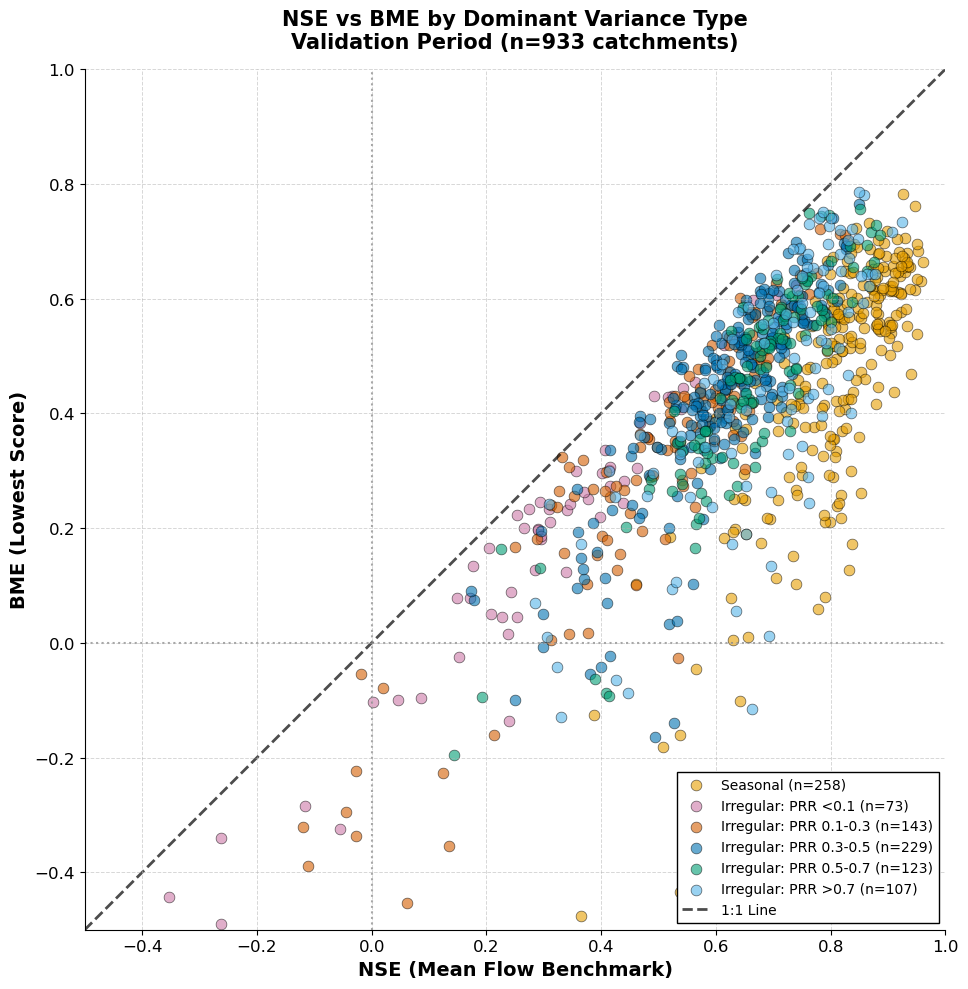

In [20]:
fig, df_comparison = plot_nse_vs_bme_scatter(df_merged, period='validation', save_prefix='nse_vs_bme')

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_nse_vs_bme_scatter(df, period='all', save_prefix='nse_vs_bme'):
    """
    Create a scatter plot comparing mean flow benchmark (NSE) vs lowest benchmark (BME)
    Color-coded by dominant variance type and runoff ratio classes
    
    Parameters:
    -----------
    df : DataFrame with benchmark scores (merged_df with dominant_variance column)
    period : str, which period to analyze ('calibration', 'validation', 'all')
    save_prefix : str, prefix for output files
    """
    
    # Filter for the specified period
    df_period = df[df['period'] == period].copy()
    
    # Reset index if catchment is in index
    if 'catchment' not in df_period.columns:
        df_period = df_period.reset_index()
    
    # Get mean flow benchmark scores (NSE)
    df_nse = df_period[df_period['benchmark'] == 'bm_mean_flow'][['catchment', 'skill_score', 'dominant_variance']].copy()
    df_nse.columns = ['catchment', 'NSE', 'dominant_variance']
    
    # For each catchment, find the MINIMUM (worst) benchmark score (BME)
    if 'lowest' in df_period['benchmark'].values:
        df_bme = df_period[df_period['benchmark'] == 'lowest'][['catchment', 'skill_score']].copy()
        df_bme.columns = ['catchment', 'BME']
    else:
        # Find the worst (lowest/minimum) benchmark score for each catchment
        df_bme = df_period.groupby('catchment')['skill_score'].min().reset_index()
        df_bme.columns = ['catchment', 'BME']
    
    # Get runoff ratio for each catchment (from any row since it's catchment-specific)
    df_runoff = df_period.groupby('catchment')['runoff_ratio_mean'].first().reset_index()
    
    # Merge NSE, BME, and runoff ratio
    df_comparison = df_nse.merge(df_bme, on='catchment', how='inner')
    df_comparison = df_comparison.merge(df_runoff, on='catchment', how='inner')
    
    # Remove any NaN values
    df_comparison = df_comparison.dropna()
    
    # Filter for only seasonal and irregular variance
    df_comparison = df_comparison[df_comparison['dominant_variance'].isin(['seasonal', 'irregular'])].copy()
    
    # Create runoff ratio bins for irregular catchments
    df_comparison['runoff_class'] = 'N/A'
    irregular_mask = df_comparison['dominant_variance'] == 'irregular'
    df_comparison.loc[irregular_mask, 'runoff_class'] = pd.cut(
        df_comparison.loc[irregular_mask, 'runoff_ratio_mean'],
        bins=[0, 0.1, 0.3, 0.5, 0.7, np.inf],
        labels=['PRR <0.1', 'PRR 0.1-0.3', 'PRR 0.3-0.5', 
                'PRR 0.5-0.7', 'PRR >0.7']
    )
    
    # Create combined category for coloring
    df_comparison['category'] = df_comparison['dominant_variance']
    df_comparison.loc[irregular_mask, 'category'] = (
        'Irregular: ' + df_comparison.loc[irregular_mask, 'runoff_class'].astype(str)
    )
    
    # Capitalize seasonal
    df_comparison['category'] = df_comparison['category'].replace('seasonal', 'Seasonal')
    
    print(f"\n{'='*80}")
    print(f"NSE vs BME Comparison - {period.upper()} Period")
    print(f"{'='*80}")
    print(f"Number of catchments: {len(df_comparison)}")
    print(f"\nNSE (Mean Flow Benchmark) Statistics:")
    print(f"  Mean:   {df_comparison['NSE'].mean():.3f}")
    print(f"  Median: {df_comparison['NSE'].median():.3f}")
    print(f"  Min:    {df_comparison['NSE'].min():.3f}")
    print(f"  Max:    {df_comparison['NSE'].max():.3f}")
    
    print(f"\nBME (Worst Benchmark - Minimum Score) Statistics:")
    print(f"  Mean:   {df_comparison['BME'].mean():.3f}")
    print(f"  Median: {df_comparison['BME'].median():.3f}")
    print(f"  Min:    {df_comparison['BME'].min():.3f}")
    print(f"  Max:    {df_comparison['BME'].max():.3f}")
    
    # Calculate difference
    df_comparison['difference'] = df_comparison['NSE'] - df_comparison['BME']
    print(f"\nDifference (NSE - BME):")
    print(f"  Mean difference:   {df_comparison['difference'].mean():.3f}")
    print(f"  Median difference: {df_comparison['difference'].median():.3f}")
    
    # Print category counts
    print(f"\nCatchments by Category:")
    for cat in df_comparison['category'].unique():
        count = (df_comparison['category'] == cat).sum()
        print(f"  {cat}: {count}")
    
    # ========================================================================
    # Create 2x3 grid of scatter plots
    # ========================================================================
    
    # Define colors for categories
    color_map = {
        'Seasonal': '#E69F00',  # Orange
        'Irregular: PRR <0.1': '#CC79A7',  # Pink
        'Irregular: PRR 0.1-0.3': '#D55E00',  # Red-orange
        'Irregular: PRR 0.3-0.5': '#0072B2',  # Blue
        'Irregular: PRR 0.5-0.7': '#009E73',  # Green
        'Irregular: PRR >0.7': '#56B4E9',  # Light blue
    }
    
    # Define order for subplots (seasonal first, then irregular by increasing PRR)
    category_order = [
        'Seasonal',
        'Irregular: PRR <0.1',
        'Irregular: PRR 0.1-0.3',
        'Irregular: PRR 0.3-0.5',
        'Irregular: PRR 0.5-0.7',
        'Irregular: PRR >0.7'
    ]
    
    # Create figure with 3 rows × 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(16, 22))
    axes = axes.flatten()
    
    # Set fixed limits
    lim_min = -0.5
    lim_max = 1.0
    
    # Plot each category in its own subplot
    for idx, category in enumerate(category_order):
        ax = axes[idx]
        
        # Plot grey background points (all other categories) - SAME SIZE, DARKER
        other_data = df_comparison[df_comparison['category'] != category]
        if len(other_data) > 0:
            ax.scatter(other_data['NSE'], other_data['BME'], 
                      c='#888888', s=80, alpha=0.4,
                      edgecolors='none', zorder=1)
        
        # Plot highlighted category in color
        highlight_data = df_comparison[df_comparison['category'] == category]
        count = len(highlight_data)
        
        if count > 0:
            ax.scatter(highlight_data['NSE'], highlight_data['BME'], 
                      c=[color_map.get(category, '#888888')], 
                      s=80, alpha=0.8,
                      edgecolors='k', linewidth=0.7,
                      label=f'{category} (n={count})',
                      zorder=2)
        
        # Add 1:1 line
        ax.plot([lim_min, lim_max], [lim_min, lim_max], 
                'k--', linewidth=1.5, alpha=0.5, zorder=0)
        
        # Add horizontal and vertical lines at 0
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5, zorder=0)
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5, zorder=0)
        
        # Set limits
        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        
        # Labels (only on bottom row and left column) - INCREASED FONT SIZE
        if idx >= 4:  # Bottom row
            ax.set_xlabel('Mean Flow Benchmark (NSE)', fontsize=16, weight='bold')  # Changed from 12 to 16, updated label
        else:
            ax.set_xlabel('')
            
        if idx % 2 == 0:  # Left column
            ax.set_ylabel('BME (Lowest Score)', fontsize=16, weight='bold')  # Changed from 12 to 16
        else:
            ax.set_ylabel('')
        
        # Title with category name and count - INCREASED FONT SIZE
        ax.set_title(f'({chr(97+idx)}) {category}\n(n={count} catchments)',
                    fontsize=16, weight='bold', pad=10)  # Changed from 13 to 16
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Equal aspect ratio for proper 1:1 line
        ax.set_aspect('equal', adjustable='box')
        
        # Styling - INCREASED TICK LABEL SIZE
        ax.tick_params(labelsize=13)  # Changed from 10 to 13
        sns.despine(ax=ax)
    
    # Overall title - INCREASED FONT SIZE
    fig.suptitle(
        f'NSE vs BME by Dominant Variance Type and Runoff Ratio\n'
        f'{period.capitalize()} Period (n={len(df_comparison)} catchments)',
        fontsize=18, weight='bold', y=0.995)  # Changed from 16 to 18
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter_grid.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{save_prefix}_{period}_scatter_grid.pdf', dpi=300, bbox_inches='tight')
    
    return fig, df_comparison


# ============================================================================
# Example usage
# ============================================================================

if __name__ == "__main__":
    # Example usage:
    # fig, df_comp = plot_nse_vs_bme_scatter(df, period='all')
    pass


NSE vs BME Comparison - VALIDATION Period
Number of catchments: 933

NSE (Mean Flow Benchmark) Statistics:
  Mean:   0.450
  Median: 0.666
  Min:    -88.798
  Max:    0.961

BME (Worst Benchmark - Minimum Score) Statistics:
  Mean:   0.140
  Median: 0.442
  Min:    -105.818
  Max:    0.785

Difference (NSE - BME):
  Mean difference:   0.310
  Median difference: 0.209

Catchments by Category:
  Seasonal: 258
  Irregular: PRR 0.1-0.3: 143
  Irregular: PRR 0.5-0.7: 123
  Irregular: PRR >0.7: 107
  Irregular: PRR <0.1: 73
  Irregular: PRR 0.3-0.5: 229


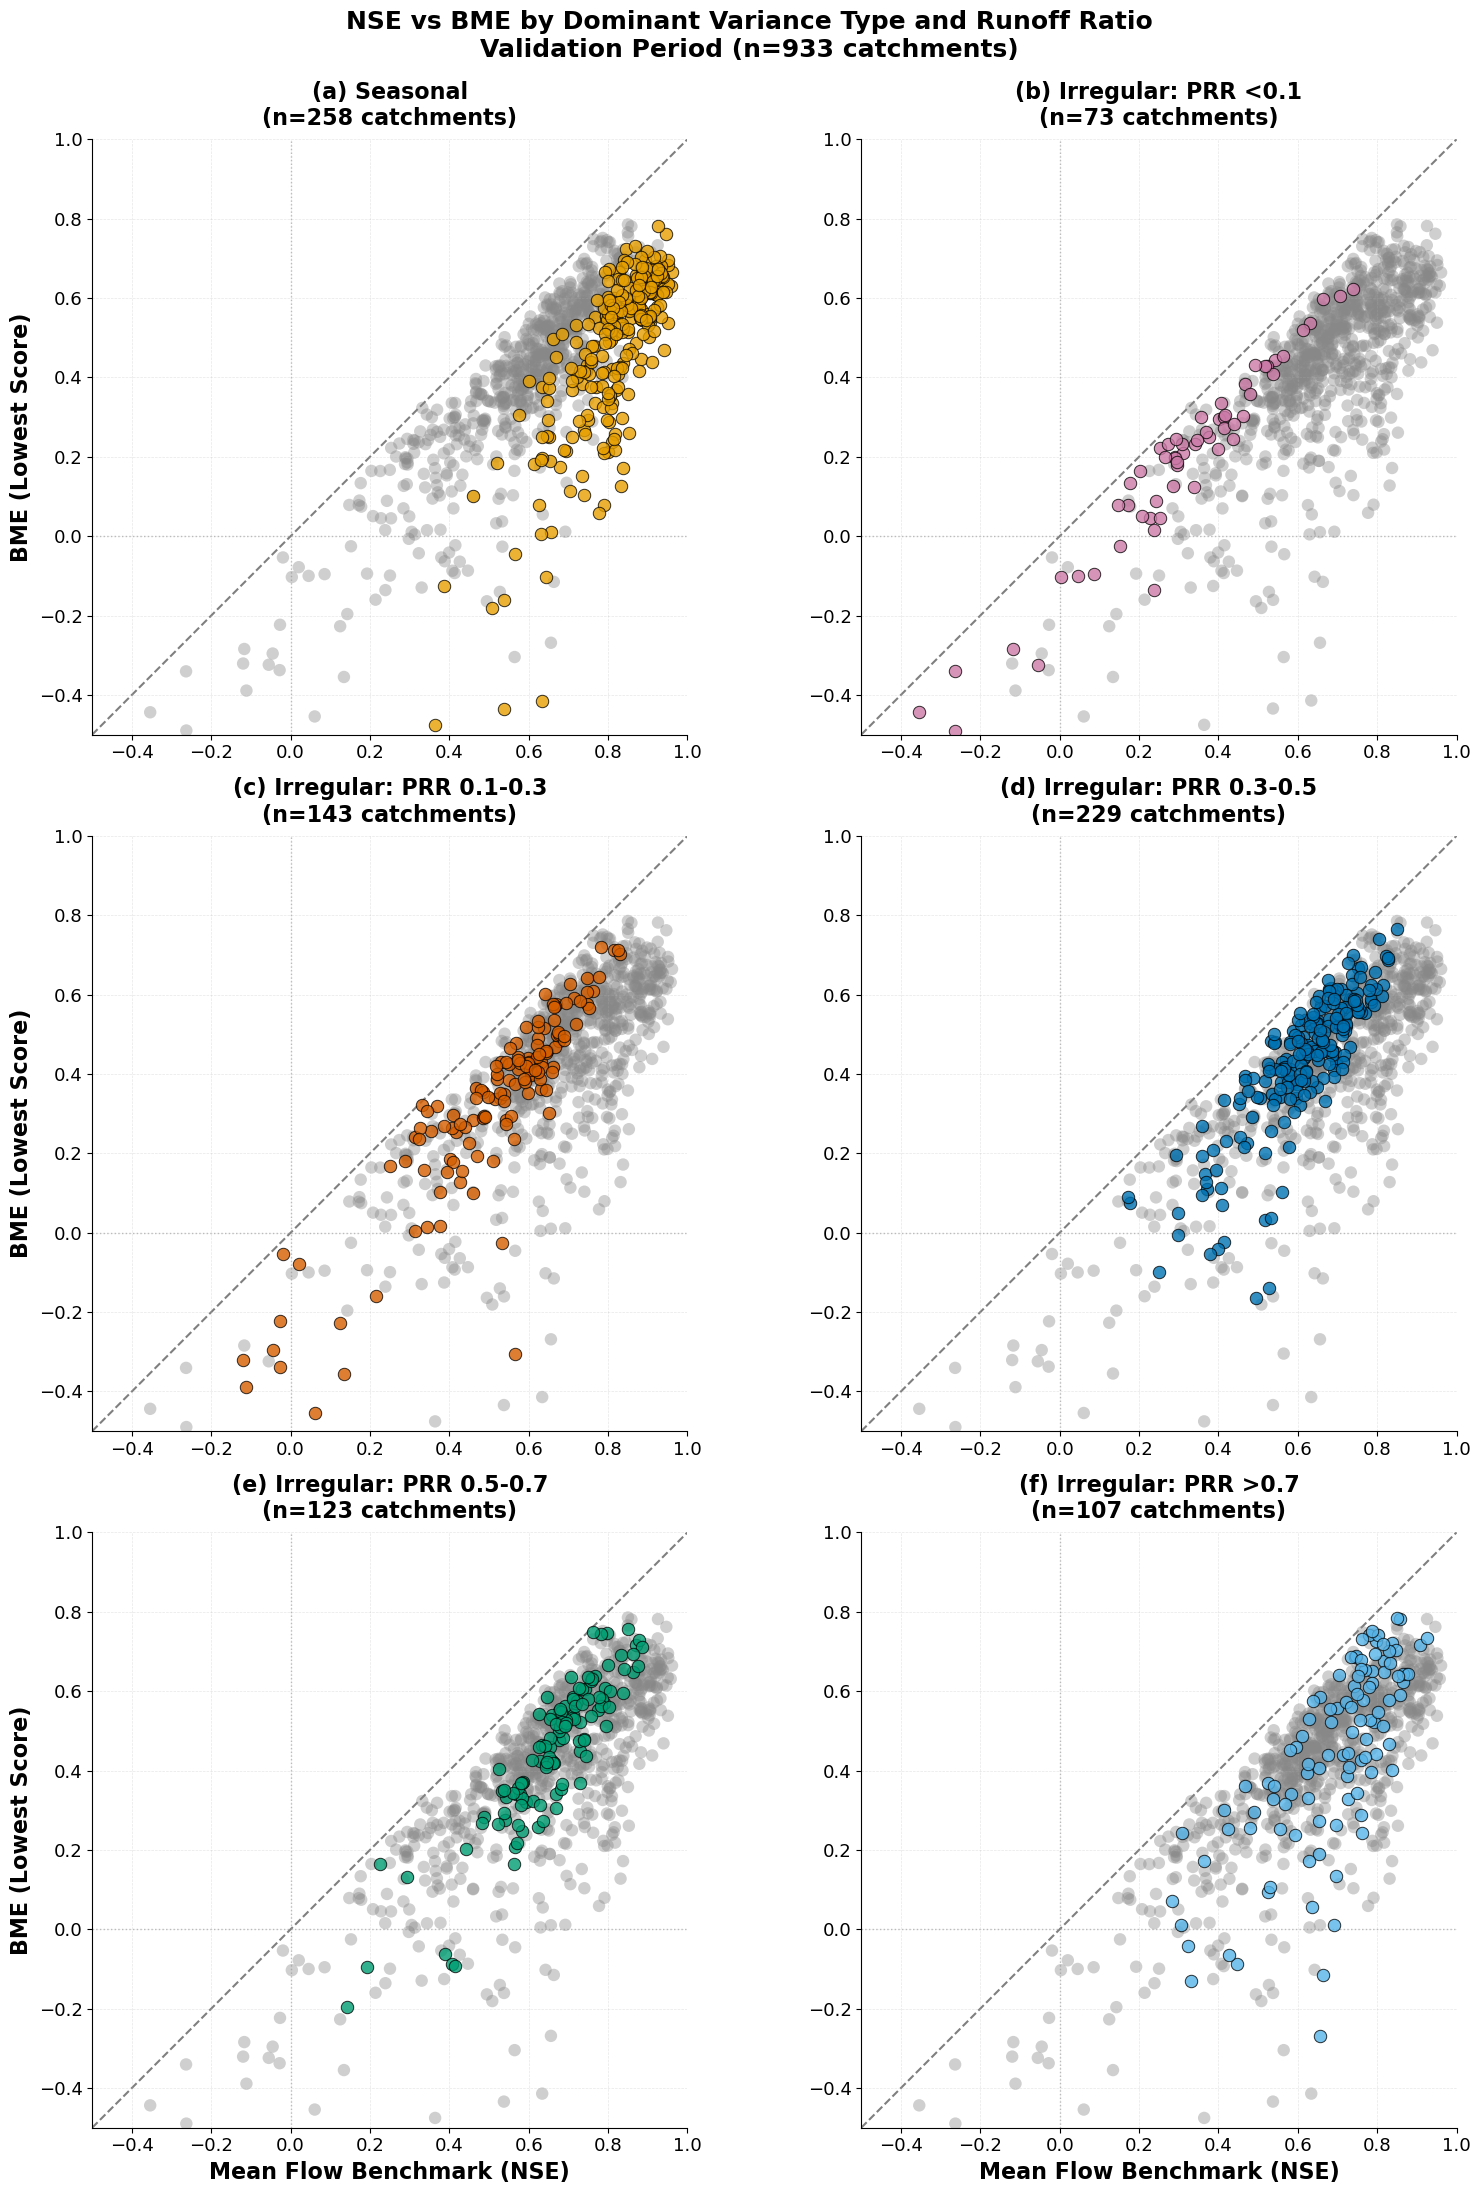

In [28]:
fig_grid, df_comparison_grid = plot_nse_vs_bme_scatter(df_merged, period='validation', save_prefix='nse_vs_bme')